In [1]:
import os
import torch
from YOLO import *
from label_map import *
from data.util import read_image
from utils.vis_tool import vis_bbox
from utils import array_tool as at
import numpy as np
%matplotlib inline

## Load Datasets and Model

/opt/conda/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


tensor([[102.4928,  94.0917, 260.1282, 387.0441],
        [ 19.8389, 105.7823,  96.7787, 264.1694],
        [ 11.7726, 101.5395,  41.3455, 124.8371]])


TypeError: list indices must be integers or slices, not numpy.float32

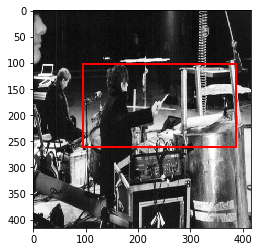

In [22]:
from PascalVOCDataloader import PascalVOCDataloader, create_split_loaders
data_dir = '/datasets/ee285f-public/PascalVOC2012/'
model_dir = 'YOLO/cfg/'
test_file = 'YOLO_Pretrained'

# Load Dataset
dataset = PascalVOCDataloader(data_dir, normalize=True, YOLO=True)
train_loader, val_loader, test_loader = create_split_loaders(dataset,batch_size=1)

# Load Model
#faster_rcnn = FasterRCNNVGG16()
yolo = Darknet("YOLO/cfg/yolov3.cfg")
yolo.load_weights("YOLO/yolov3.weights")
#trainer = FasterRCNNTrainer(faster_rcnn).cuda()
#trainer.load(model_dir+'fasterrcnn_12211511_0.701052458187_torchvision_pretrain')
img, q, e = next(iter(val_loader))

det = yolo(img, CUDA=False)

op = write_results(det,0.5,80,0.4)
_bboxes = op[:,1:5]
_labels = op[:,-1]
_scores = op[:,-2]
print(_bboxes)
#_bboxes, _labels, _scores = trainer.faster_rcnn.predict(img,visualize=False, score_thresh=0.7)
vis_bbox(at.tonumpy(img[0]),
         at.tonumpy(_bboxes),
         at.tonumpy(_labels).reshape(-1),
         at.tonumpy(_scores).reshape(-1))

torch.Size([1, 8])
torch.Size([1, 10647, 85])
torch.Size([1]) torch.Size([1, 4]) torch.Size([1])


TypeError: list indices must be integers or slices, not numpy.float32

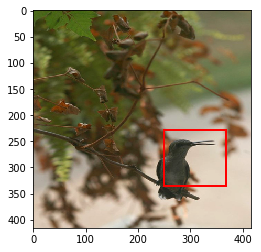

In [3]:
op = write_results(det,0.5,80,0.4)
print(op.shape)
print(_bboxes)
print(det.shape)
_bboxes = op[:,1:5]
_labels = op[:,-1]
_scores = op[:,-2]
for idx,l in enumerate(pred_labels):
    _labels[idx] = coco_to_pascal[l]
print(_labels.shape, _bboxes.shape, _scores.shape)
vis_bbox(at.tonumpy(img[0]),
         at.tonumpy(_bboxes),
         at.tonumpy(_labels).reshape(-1),
         at.tonumpy(_scores).reshape(-1))


## Evaluate and Save Testing Outputs

In [ ]:
import pandas as pd
n_classes = 20
class_labels = [ 1, 5, 6, 7, 9, 11, 12, 13, 14, 16, 18]

### Load Results into Dataframe ###
PRED_COL = ['img_num', 'pred_bboxes', 'pred_labels', 'pred_scores']
Predicted_Data = pd.DataFrame(columns=PRED_COL)
TRUE_COL = ['img_num', 'true_bboxes', 'true_labels']
True_Data = pd.DataFrame(columns=TRUE_COL)
n_pred_bboxes = 0
n_pred_thresh = 10
class_check = np.zeros((n_classes))
import time


for img_num, (img, true_bboxes, true_labels) in enumerate(test_loader, 0):
    true_bboxes, true_labels, = true_bboxes.numpy()[0], true_labels.numpy()[0]
    start_time = time.time()
    det = yolo(img, CUDA=False)
    output = write_results(det,0.5,80,0.4)
    print('Epoch', start_time - time.time())
    pred_bboxes = output[:,1:5]
    pred_labels = output[:,-1]
    pred_scores = output[:,-2]
    
    for idx,l in enumerate(pred_labels):
        pred_labels[idx] = coco_to_pascal[l]
    
    #pred_bboxes, pred_labels, pred_scores = trainer.faster_rcnn.predict(img,visualize=False, score_thresh=0.45) # YOLO model pred
    pred_bboxes, pred_labels, pred_scores = np.asarray(pred_bboxes)[0], np.asarray(pred_labels)[0], np.asarray(pred_scores)[0]
    print(pred_bboxes.shape)
    n_pred = pred_bboxes.shape[0]
    for i in range(n_pred):
        tmp_df = pd.DataFrame([[img_num, pred_bboxes[i], pred_labels[i], pred_scores[i]]], columns=PRED_COL) # COCO to PAs
        Predicted_Data = Predicted_Data.append(tmp_df, ignore_index=True)
    n_true = true_bboxes.shape[0]
    for i in range(n_true):
        tmp_df = pd.DataFrame([[img_num, true_bboxes[i], true_labels[i]]], columns=TRUE_COL)
        True_Data = True_Data.append(tmp_df, ignore_index=True)
        class_check[true_labels[i]] = 1
    n_pred_bboxes += pred_bboxes.shape[0]
    cc = class_check[class_labels]
    print(np.sum(cc))
    if (n_pred_bboxes > n_pred_thresh and (np.sum(cc) == len(class_labels))):
        print('Test conditions reached with %d test images and %d predicted boxes' % (img_num, n_pred_bboxes))
        break

#Predicted_Data.to_pickle(test_file+'_Predicted_Data.pkl')
#True_Data.to_pickle(test_file+'_True_Data.pkl')
print(Predicted_Data.shape[0])


## Calculate Precision and Recall

In [20]:
from IoU import bb_intersection_over_union
Predicted_Data = pd.read_pickle(test_file+'_Predicted_Data.pkl')
#print(Predicted_Data)
True_Data = pd.read_pickle(test_file+'_True_Data.pkl')
#True_Data.to_pickle('RCNN_True_Data.pkl')
Predicted_Data.sort_values(['pred_scores'], axis=0, ascending=False, inplace=True)
Predicted_Data.reset_index(inplace=True)
#print(Predicted_Data[:4])
#print(True_Data['true_labels'].value_counts())
    

def calc_precision_recall(Predicted_Data, True_Data, class_labels):
    Predicted_Data = Predicted_Data.sort_values(['pred_scores'], axis=0, ascending=False, inplace=False)
    Predicted_Data = Predicted_Data.reset_index(inplace=False)
    n_classes = len(class_labels)
    mAP_thresh = 0.5
    
    n_pred = Predicted_Data.shape[0]
    Precision = np.zeros((n_pred))
    Recall = np.zeros((n_pred))
    TP_FN = True_Data['true_labels'].value_counts()
    n_pred = 100
    for p in range(1,n_pred+1):
        pred_data = Predicted_Data[:p]
        class_precision = []
        class_recall = []
        for c in range(n_classes):
            if  not(TP_FN.keys().contains(c)):
                continue
            cl = class_labels[c]
            pred_data_cl = pred_data.loc[pred_data['pred_labels'] == cl]
            n_bboxes = pred_data_cl.shape[0]
            TP = 0
            FP = 0
            # Check if positives are True or False
            for _,pred_row in pred_data_cl.iterrows():
                pred_bbox = pred_row['pred_bboxes']
                img_num = pred_row['img_num']
                true_data = True_Data.loc[True_Data['img_num'] == img_num]
                true_data = true_data.loc[true_data['true_labels'] == cl]
                n_true_bboxes = true_data.shape[0]
                # Calculate iou between ground truth and predictions
                max_iou = 0
                for _,true_row in true_data.iterrows():
                    true_bbox = true_row['true_bboxes']
                    print(pred_bbox)
                    print(img_num, true_bbox)
                    iou = bb_intersection_over_union(pred_bbox, true_bbox)
                    if (iou > max_iou):
                        max_iou = iou
                if (max_iou >= mAP_thresh):
                    TP += 1
                elif (max_iou < mAP_thresh):
                    FP += 1
            if (n_bboxes > 0):
                class_precision.append(TP/(TP+FP))
                class_recall.append(TP/TP_FN[cl])
        if(len(class_precision) > 0):
            Precision[p-1] = sum(class_precision)/len(class_precision)
            Recall[p-1] = sum(class_recall)/len(class_recall)

    return Precision, Recall

Precision, Recall = calc_precision_recall(Predicted_Data, True_Data, class_labels)
np.save(test_file+'_Precision.npy', Precision) 
np.save(test_file+'_Recall.npy', Recall)
#TP_FN = True_Data['true_labels'].value_counts()
#print(type(TP_FN), TP_FN.keys().contains(9))

tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[113.   0. 331. 499.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[ 95.   1. 187.  93.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[113.   0. 331. 499.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[ 95.   1. 187.  93.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[113.   0. 331. 499.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[ 95.   1. 187.  93.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[113.   0. 331. 499.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[ 95.   1. 187.  93.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[113.   0. 331. 499.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[ 95.   1. 187.  93.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[113.   0. 331. 499.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[ 95.   1. 187.  93.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[113.   0. 331. 499.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[ 95.   1. 187.  93.]
tensor

tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[239.  99. 255. 117.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[219.   0. 241.  22.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[113.   0. 331. 499.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[ 95.   1. 187.  93.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[197. 199. 304. 310.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[202. 393. 301. 499.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[233. 306. 257. 329.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[239.  99. 255. 117.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[219.   0. 241.  22.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[113.   0. 331. 499.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[ 95.   1. 187.  93.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[197. 199. 304. 310.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[202. 393. 301. 499.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[233. 306. 257. 329.]
tensor

tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[113.   0. 331. 499.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[ 95.   1. 187.  93.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[197. 199. 304. 310.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[202. 393. 301. 499.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[233. 306. 257. 329.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[239.  99. 255. 117.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[219.   0. 241.  22.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[  0.  31. 332. 486.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[  0. 274. 187. 498.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[ 78. 130. 154. 228.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[ 76. 171. 294. 475.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[257. 419. 363. 499.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[113.   0. 331. 499.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[ 95.   1. 187.  93.]
tensor

tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[113.   0. 331. 499.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[ 95.   1. 187.  93.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[197. 199. 304. 310.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[202. 393. 301. 499.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[233. 306. 257. 329.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[239.  99. 255. 117.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[219.   0. 241.  22.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[  0.  31. 332. 486.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[  0. 274. 187. 498.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[ 78. 130. 154. 228.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[ 76. 171. 294. 475.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[257. 419. 363. 499.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[113.   0. 331. 499.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[ 95.   1. 187.  93.]
tensor

tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[113.   0. 331. 499.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[ 95.   1. 187.  93.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[197. 199. 304. 310.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[202. 393. 301. 499.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[233. 306. 257. 329.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[239.  99. 255. 117.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[219.   0. 241.  22.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[  0.  31. 332. 486.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[  0. 274. 187. 498.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[ 78. 130. 154. 228.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[ 76. 171. 294. 475.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[257. 419. 363. 499.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[ 70.   0. 222. 102.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[50.  0. 70. 62.]
tensor([ -

tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[197. 199. 304. 310.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[202. 393. 301. 499.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[233. 306. 257. 329.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[239.  99. 255. 117.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[219.   0. 241.  22.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[  0.  31. 332. 486.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[  0. 274. 187. 498.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[ 78. 130. 154. 228.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[ 76. 171. 294. 475.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[257. 419. 363. 499.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[ 70.   0. 222. 102.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[50.  0. 70. 62.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[ 45.  79. 341. 448.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[125. 248. 177. 332.]
tensor([ -

tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[257. 419. 363. 499.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[ 70.   0. 222. 102.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[50.  0. 70. 62.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[ 45.  79. 341. 448.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[125. 248. 177. 332.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[158. 128. 170. 152.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[155. 151. 218. 302.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[182. 337. 283. 398.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[113.   0. 331. 499.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[ 95.   1. 187.  93.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[197. 199. 304. 310.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[202. 393. 301. 499.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[233. 306. 257. 329.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[239.  99. 255. 117.]
tensor([ -

tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[113.   0. 331. 499.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[ 95.   1. 187.  93.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[197. 199. 304. 310.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[202. 393. 301. 499.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[233. 306. 257. 329.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[239.  99. 255. 117.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[219.   0. 241.  22.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[  0.  31. 332. 486.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[  0. 274. 187. 498.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[ 78. 130. 154. 228.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[ 76. 171. 294. 475.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[257. 419. 363. 499.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[ 70.   0. 222. 102.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[50.  0. 70. 62.]
tensor([ -

tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[125. 248. 177. 332.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[158. 128. 170. 152.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[155. 151. 218. 302.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[182. 337. 283. 398.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[ 58.  88. 288. 454.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[ 59. 330. 167. 499.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[ 62. 239. 105. 390.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[113.   0. 331. 499.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[ 95.   1. 187.  93.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[197. 199. 304. 310.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[202. 393. 301. 499.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[233. 306. 257. 329.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[239.  99. 255. 117.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[219.   0. 241.  22.]
tensor

tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[ 70.   0. 222. 102.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[50.  0. 70. 62.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[ 45.  79. 341. 448.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[125. 248. 177. 332.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[158. 128. 170. 152.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[155. 151. 218. 302.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[182. 337. 283. 398.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[ 58.  88. 288. 454.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[ 59. 330. 167. 499.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[ 62. 239. 105. 390.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[113.   0. 331. 499.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[ 95.   1. 187.  93.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[197. 199. 304. 310.]
tensor([ -9.2695,  15.8400, 420.1481, 417.6072])
[202. 393. 301. 499.]
tensor([ -

## Plot Total PR Curve and Calculate mAP

[0.02564103 0.025      0.02439024 0.02380952 0.02325581 0.02272727
 0.02222222 0.02173913 0.0212766  0.02083333 0.02040816 0.02
 0.01960784 0.01923077 0.01886792 0.01851852 0.01818182 0.01785714
 0.01754386 0.01724138 0.01694915 0.01666667 0.01639344 0.01612903
 0.01587302 0.015625   0.01538462 0.01515152 0.02985075 0.02941176
 0.02898551 0.02857143 0.02816901 0.02777778 0.02739726 0.02702703
 0.02666667 0.02631579 0.02597403 0.02564103 0.02531646 0.025
 0.02469136 0.02439024 0.02409639 0.02380952 0.02352941 0.02325581
 0.02298851 0.02272727 0.02247191 0.02222222 0.02197802 0.02173913
 0.02150538 0.0212766  0.02105263 0.02083333 0.02061856 0.02040816
 0.02020202 0.02      ]
0.005427408412483039


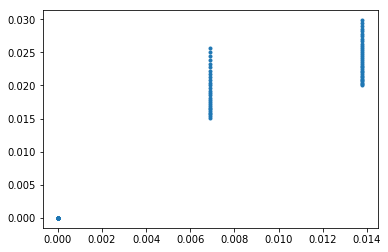

In [18]:
Precision = np.load(test_file+'_Precision.npy') 
Recall = np.load(test_file+'_Recall.npy')
from matplotlib import pyplot as plt
plt.plot(Recall, Precision, '.')
#print(Precision, Recall)
def calculate_mAP(Recall, Precision):
    N = Precision.shape[0]
    # Smooth precision curve
    for i in range(N-1):
        ind_right = (Recall >= Recall[i])
        Precision[i] = max(Precision[i], np.max(Precision[ind_right]))
    # Interpolate PR values
    recall_steps = np.linspace(0,1,11)
    Interp_Precision = np.zeros(11)
    for i in range(11):
        r = recall_steps[i]
        ind_closest = np.argmin(np.absolute(r - Recall))
        if (np.absolute(Recall[ind_closest] - r) <= 0.1):
            Interp_Precision[i] = Precision[ind_closest]
            Recall[ind_closest] = 0
    mAP = np.sum(Interp_Precision)/11
    return mAP

mAP = calculate_mAP(Recall, Precision)
print(mAP)

## Plot Class Specific PR Curves

In [ ]:
from matplotlib import pyplot as plt

Predicted_Data = pd.read_pickle(test_file+'_Predicted_Data.pkl')
True_Data = pd.read_pickle(test_file+'_True_Data.pkl')


classes = {0:'Aeroplane', 1:'Bicycle',2:'Bird',3:'Boat',4:'Bottle',5:'Bus',
                        6:'Car', 7:'Cat',8:'Chair',9:'Cow',10:'Diningtable',11:'Dog',
                        12:'Horse', 13:'Motorbike',14:'Person',15:'Potted Plant',
                        16:'Sheep', 17:'Sofa',18:'Train',19:'Tv Monitor'}
# Plot Precision Recall for each class
fig = plt.figure()
fig.set_figheight(16)
fig.set_figwidth(20)
for c in class_labels:
    P,R = calc_precision_recall(Predicted_Data, True_Data, [c])
    plt.subplot(5, 4, c+1)
    plt.plot(R, P, '.')
    plt.xlabel('Recall',fontsize=16)
    plt.ylabel('Precision',fontsize=16)
    plt.title(' Class = '+ classes[c],fontsize=20)
    plt.rc('xtick',labelsize=14)
    plt.rc('ytick',labelsize=14)
    plt.tight_layout()
plt.show()
fig.savefig('plot/'+test_file+'_Class_PR.png')